In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from pathlib import Path
import os

In [183]:
aapl = 'stock-price-predictions/price/AAPL.csv'
df = pd.read_csv(aapl)
df.drop(['High', 'Low'], axis=1, inplace=True)
df['Percentage Change'] = df['Close'].pct_change()

## TA Prep

In [184]:
df['20SMA'] = df['Close'].rolling(window=20).mean()
df['50SMA'] = df['Close'].rolling(window=50).mean()

df['Std Dev'] = df['Close'].rolling(window=20).std()

df

,Date,Open,Close,Adj Close,Volume,Percentage Change,20SMA,50SMA,Std Dev
0,2012-09-04,95.108574,96.424286,87.121140,91973000,NaN,NaN,NaN,NaN
1,2012-09-05,96.510002,95.747147,86.509338,84093800,-0.007022,NaN,NaN,NaN
2,2012-09-06,96.167145,96.610001,87.288956,97799100,0.009012,NaN,NaN,NaN
3,2012-09-07,96.864288,97.205711,87.827171,82416600,0.006166,NaN,NaN,NaN
4,2012-09-10,97.207146,94.677139,85.542564,121999500,-0.026013,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1253,2017-08-28,160.139999,161.470001,161.470001,25966000,0.010071,158.361501,151.708600,2.731928
1254,2017-08-29,160.100006,162.910004,162.910004,29516900,0.008918,159.004501,152.040000,2.116900
1255,2017-08-30,163.800003,163.350006,163.350006,27269600,0.002701,159.315002,152.406801,2.278306
1256,2017-08-31,163.639999,164.000000,164.000000,26785100,0.003979,159.736501,152.769401,2.328246


## Bollinger Bands
* Determine where price volatility exceeds a prior window range

In [185]:
df['UpperB'] = df['20SMA'] + 2 * df['Std Dev']
df['LowerB'] = df['20SMA'] - 2 * df['Std Dev']

In [186]:
df['BB Signal'] = 0
df['BB Signal'] = np.where(df['Close'] < df['LowerB'], 1, df['BB Signal'])
df['BB Signal'] = np.where(df['Close'] > df['UpperB'], -1, df['BB Signal'])

In [187]:
df['BB Z-Score'] = (df['Close'] - df['20SMA']) / df['Std Dev']

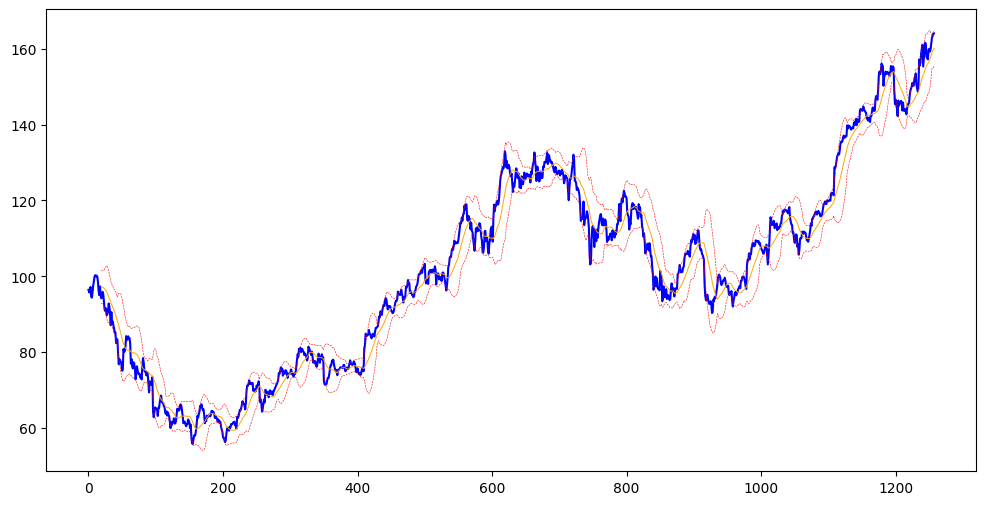

In [188]:
# plot bollinger bands
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='AAPL', color='blue')
plt.plot(df['20SMA'], label='SMA', color='orange', linewidth=0.7)
plt.plot(df['UpperB'], label='Upper Bollinger Band', color='red', linewidth=0.4, linestyle='dashed')
plt.plot(df['LowerB'], label='Lower Bollinger Band', color='red', linewidth=0.4, linestyle='dashed')

## Relative Strength Index (RSI)
* Measure the velocity/size of price fluctuations to determine over/under-valued prices

In [189]:
rsi_period = 14

rsi_buy = 70
rsi_sell = 30

In [190]:
RS = df['Close'].diff()
gain = (RS.where(RS > 0, 0)).rolling(window=rsi_period).mean()
loss = (-RS.where(RS < 0, 0)).rolling(window=rsi_period).mean()

rs = gain / loss
rsi = 100 - (100 / (1 + rs))

In [191]:
df['RSI'] = rsi
df['RSI_Mean'] = df['RSI'].rolling(window=14).mean()  # 14-period rolling mean of RSI
df['RSI_Std'] = df['RSI'].rolling(window=14).std()    # 14-period rolling standard deviation of RSI

In [192]:
df['RSI Signal'] = 0  # 0: no signal, 1: buy, -1: sell
df.loc[(df['20SMA'] > df['50SMA']) & (rsi < rsi_buy), 'RSI Signal'] = 1
df.loc[(df['20SMA'] < df['50SMA']) & (rsi > rsi_sell), 'RSI Signal'] = -1

In [193]:
df['RSI Z-Score'] = (df['RSI'] - df['RSI_Mean']) / df['RSI_Std']  # Z-Score of RSI

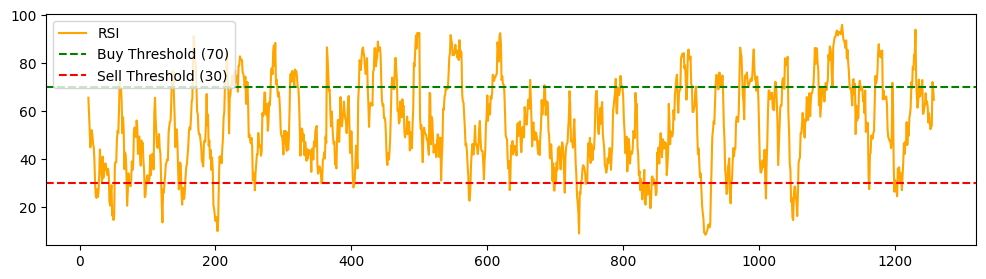

In [194]:
plt.figure(figsize=(12, 3))
plt.plot(rsi, label='RSI', color='orange')
plt.axhline(y=rsi_buy, color='g', linestyle='--', label=f'Buy Threshold ({rsi_buy})')
plt.axhline(y=rsi_sell, color='r', linestyle='--', label=f'Sell Threshold ({rsi_sell})')
plt.legend(loc='upper left')

## Buy/Sell Recs

In [195]:
print(df['BB Signal'].value_counts())
print(df['RSI Signal'].value_counts())

BB Signal
 0    1108
-1      88
 1      62
Name: count, dtype: int64
RSI Signal
 1    500
-1    415
 0    343
Name: count, dtype: int64


In [196]:
df

,Date,Open,Close,Adj Close,Volume,Percentage Change,20SMA,50SMA,Std Dev,UpperB,LowerB,BB Signal,BB Z-Score,RSI,RSI_Mean,RSI_Std,RSI Signal,RSI Z-Score
0,2012-09-04,95.108574,96.424286,87.121140,91973000,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
1,2012-09-05,96.510002,95.747147,86.509338,84093800,-0.007022,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
2,2012-09-06,96.167145,96.610001,87.288956,97799100,0.009012,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
3,2012-09-07,96.864288,97.205711,87.827171,82416600,0.006166,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
4,2012-09-10,97.207146,94.677139,85.542564,121999500,-0.026013,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2017-08-28,160.139999,161.470001,161.470001,25966000,0.010071,158.361501,151.708600,2.731928,163.825357,152.897646,0,1.137841,53.012573,60.419640,5.586140,1,-1.325972
1254,2017-08-29,160.100006,162.910004,162.910004,29516900,0.008918,159.004501,152.040000,2.116900,163.238301,154.770701,0,1.844916,53.931169,59.068479,4.538353,1,-1.131977
1255,2017-08-30,163.800003,163.350006,163.350006,27269600,0.002701,159.315002,152.406801,2.278306,163.871614,154.758390,0,1.771055,72.024156,60.022487,5.702252,0,2.104725
1256,2017-08-31,163.639999,164.000000,164.000000,26785100,0.003979,159.736501,152.769401,2.328246,164.392993,155.080009,0,1.831206,69.497636,60.761969,6.226842,1,1.402905


In [197]:
df['Combined Signal'] = 0

df.loc[(df['BB Signal'] == 1) & (df['RSI Signal'] == 1), 'Combined Signal'] = 1
df.loc[(df['BB Signal'] == -1) & (df['RSI Signal'] == -1), 'Combined Signal'] = -1

In [198]:
df['Combined Signal'].value_counts()

Combined Signal
 0    1195
 1      34
-1      29
Name: count, dtype: int64

In [199]:
df

,Date,Open,Close,Adj Close,Volume,Percentage Change,20SMA,50SMA,Std Dev,UpperB,LowerB,BB Signal,BB Z-Score,RSI,RSI_Mean,RSI_Std,RSI Signal,RSI Z-Score,Combined Signal
0,2012-09-04,95.108574,96.424286,87.121140,91973000,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0
1,2012-09-05,96.510002,95.747147,86.509338,84093800,-0.007022,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0
2,2012-09-06,96.167145,96.610001,87.288956,97799100,0.009012,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0
3,2012-09-07,96.864288,97.205711,87.827171,82416600,0.006166,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0
4,2012-09-10,97.207146,94.677139,85.542564,121999500,-0.026013,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2017-08-28,160.139999,161.470001,161.470001,25966000,0.010071,158.361501,151.708600,2.731928,163.825357,152.897646,0,1.137841,53.012573,60.419640,5.586140,1,-1.325972,0
1254,2017-08-29,160.100006,162.910004,162.910004,29516900,0.008918,159.004501,152.040000,2.116900,163.238301,154.770701,0,1.844916,53.931169,59.068479,4.538353,1,-1.131977,0
1255,2017-08-30,163.800003,163.350006,163.350006,27269600,0.002701,159.315002,152.406801,2.278306,163.871614,154.758390,0,1.771055,72.024156,60.022487,5.702252,0,2.104725,0
1256,2017-08-31,163.639999,164.000000,164.000000,26785100,0.003979,159.736501,152.769401,2.328246,164.392993,155.080009,0,1.831206,69.497636,60.761969,6.226842,1,1.402905,0


## Plotting Strategies

### Bollenger Bands

In [200]:
bb_buy = df['BB Signal'] == 1
bb_sell = df['BB Signal'] == -1

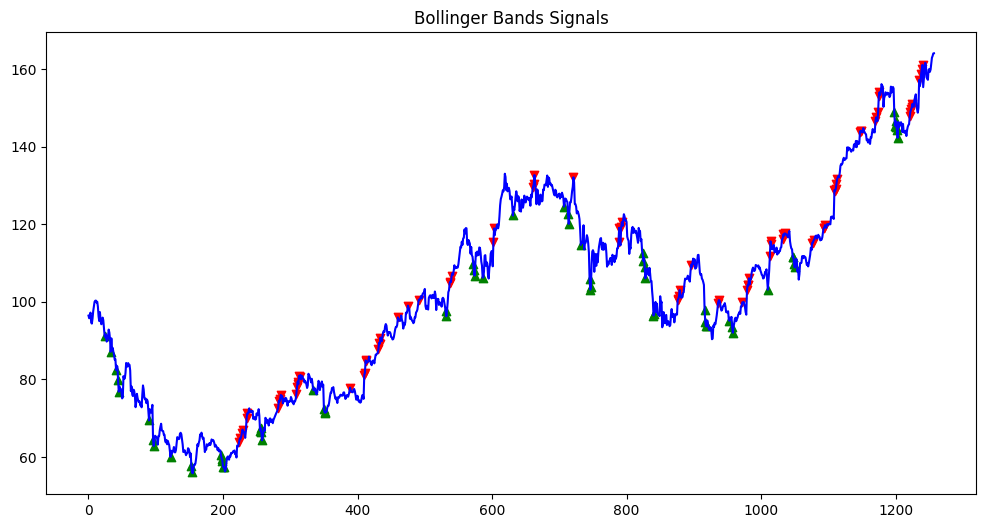

In [201]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='AAPL', color='blue')

plt.scatter(df.index[bb_buy], df['Close'][bb_buy], marker='^', color='g', label='Buy Signal')
plt.scatter(df.index[bb_sell], df['Close'][bb_sell], marker='v', color='r', label='Sell Signal')

plt.title('Bollinger Bands Signals')
plt.show()

### RSI

In [202]:
rsi_buy = df['RSI Signal'] == 1
rsi_sell = df['RSI Signal'] == -1

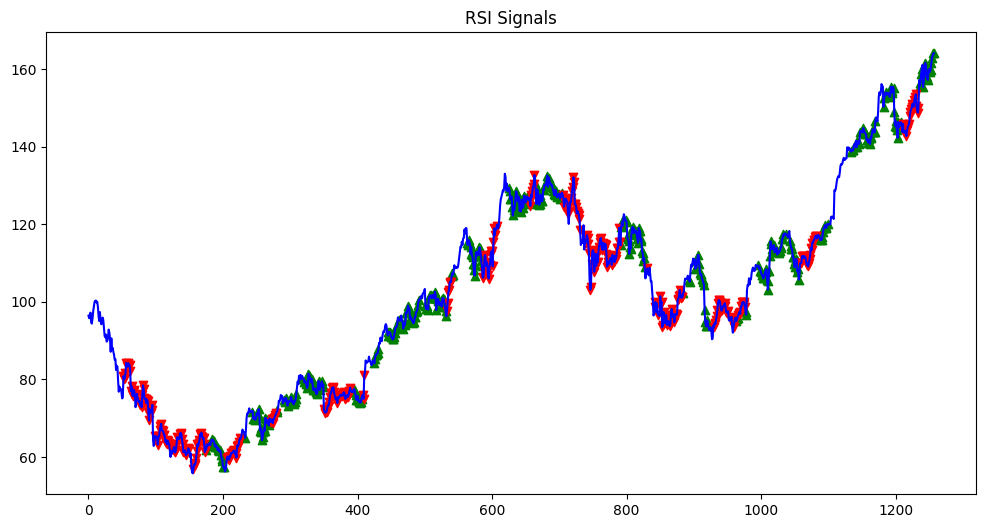

In [203]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='AAPL', color='blue')
plt.scatter(df.index[rsi_buy], df['Close'][rsi_buy], marker='^', color='g', label='Buy Signal')
plt.scatter(df.index[rsi_sell], df['Close'][rsi_sell], marker='v', color='r', label='Sell Signal')

plt.title('RSI Signals')
plt.show()

### Combined

In [204]:
combined_buy_signals = df[df['Combined Signal'] == 1]
combined_sell_signals = df[df['Combined Signal'] == -1]

[]

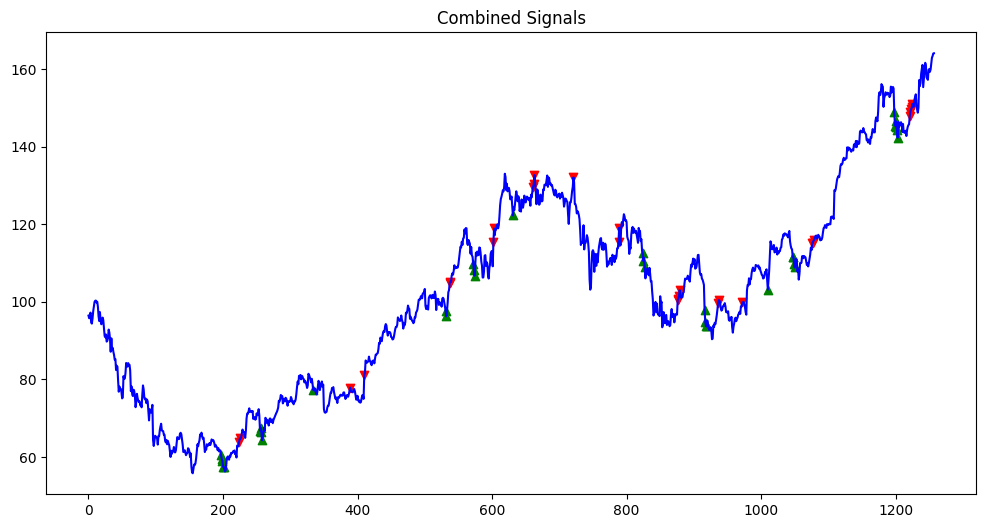

In [205]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='AAPL', color='blue')
plt.scatter(combined_buy_signals.index, combined_buy_signals['Close'], label='Buy Signal', color='green', marker='^', alpha=1)
plt.scatter(combined_sell_signals.index, combined_sell_signals['Close'], label='Sell Signal', color='red', marker='v', alpha=1)

plt.title('Combined Signals')
plt.plot()